In [122]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import ast
from collections import Counter

mpl.rcParams['figure.dpi'] = 150

In [ ]:
path = kagglehub.dataset_download("victorsoeiro/netflix-tv-shows-and-movies")

data_path_1 = os.listdir(path)[0]
full_path_1 = os.path.join(path, data_path_1)
print(f"Full Path 1: {full_path_1}")

data_path_2 = os.listdir(path)[1]
full_path_2 = os.path.join(path, data_path_2)
print(f"Full Path 2: {full_path_2}")

In [124]:
df_credits = pd.read_csv(full_path_1)
df_credits.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [125]:
df_titles = pd.read_csv(full_path_2)
df_titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [126]:
unique_ids = df_credits['id'].unique()
credits = []

top_k_actors = 10

for id in unique_ids:
    row = df_credits.loc[df_credits['id'] == id, ['name', 'role']]
    actors = row[row['role'] == 'ACTOR']['name'].tolist()
    
    if len(actors) > top_k_actors:
        actors = actors[:top_k_actors]
    
    director = row[row['role'] == 'DIRECTOR']['name'].values
    director = director[0] if len(director) == 1 else np.nan
    credits.append({'id': id, 'actors': actors, 'director': director})

df_credits_cleaned = pd.DataFrame(credits)
df_credits_cleaned.head()

,id,actors,director
0,tm84618,"[Robert De Niro, Jodie Foster, Albert Brooks, ...",Martin Scorsese
1,tm154986,"[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",John Boorman
2,tm127384,"[Graham Chapman, John Cleese, Eric Idle, Terry...",NaN
3,tm120801,"[Lee Marvin, Ernest Borgnine, Charles Bronson,...",Robert Aldrich
4,ts22164,"[Graham Chapman, Michael Palin, Terry Jones, E...",NaN


In [127]:
df_full = pd.merge(df_titles, df_credits_cleaned, on='id', how='left')
df_full.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,actors,director
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN,NaN,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,"[Robert De Niro, Jodie Foster, Albert Brooks, ...",Martin Scorsese
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,"[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",John Boorman
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,"[Graham Chapman, John Cleese, Eric Idle, Terry...",NaN
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,"[Lee Marvin, Ernest Borgnine, Charles Bronson,...",Robert Aldrich


In [128]:
credit_cols_description = [
    "The title ID on JustWatch.",
    "The name of the title.",
    "TV show or movie.",
    "A brief description.",
    "The release year.",
    "The age certification.",
    "The length of the episode (SHOW) or movie.",
    "A list of genres.",
    "A list of countries that produced the title.",
    "Number of seasons if it's a SHOW.",
    "The title ID on IMDB.",
    "Score on IMDB.",
    "Votes on IMDB.",
    "Popularity on TMDB.",
    "Score on TMDB.",
    "The person ID on JustWatch.",
    "The title ID on JustWatch.",
    "The actor or director's name.",
    "The character name.",
    "ACTOR or DIRECTOR."
]

for i, (col, desc) in enumerate(zip(df_full.columns, credit_cols_description)):
    print(f"Column {i}: {col}")
    print(f'Description: {desc}', '\n')
    print('-*'*50, '\n')

Column 0: id
Description: The title ID on JustWatch. 

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 

Column 1: title
Description: The name of the title. 

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 

Column 2: type
Description: TV show or movie. 

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 

Column 3: description
Description: A brief description. 

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 

Column 4: release_year
Description: The release year. 

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 

Column 5: age_certification
Description: The age certification. 

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 

Column 6: runtime
Description: The length of 

In [129]:
def parse_list(X):
    if X is not None:
        if isinstance(X, list):
            return X
        elif isinstance(X, str):
            if X == '' or X == '[]':
                return np.nan
            
            try:
               return ast.literal_eval(X)
            except:
                return np.nan
    else:
        return np.nan


df_full['production_countries'] = df_full['production_countries'].apply(parse_list)
df_full['genres'] = df_full['genres'].apply(parse_list)
df_full['actors'] = df_full['actors'].apply(parse_list)

In [130]:
unique_values_countries = df_full['production_countries'].explode().unique().tolist()
unique_values_genres = df_full['genres'].explode().unique().tolist()

print('Column type Unique Values:', df_full['type'].unique(), '\n')
print('Column production_countries Unique Values:', unique_values_countries, '\n')
print('Column genres Unique Values:', unique_values_genres, '\n')
print('Column age_certification Unique Values:', df_full['age_certification'].unique(), '\n')
print('Column seasons Unique Values:', df_full['seasons'].unique())

Column type Unique Values: ['SHOW' 'MOVIE'] 

Column production_countries Unique Values: ['US', 'GB', 'EG', 'DE', 'IN', 'SU', 'LB', 'CA', 'FR', nan, 'DZ', 'IT', 'JP', 'AR', 'PE', 'BR', 'IE', 'HK', 'AU', 'GH', 'BF', 'MX', 'ES', 'CO', 'PS', 'NO', 'BE', 'TR', 'DK', 'BS', 'CZ', 'MT', 'ZA', 'CN', 'BG', 'RU', 'KR', 'CL', 'MA', 'UY', 'NL', 'SE', 'TW', 'SG', 'NG', 'MY', 'Lebanon', 'CH', 'PH', 'KW', 'AT', 'XX', 'AE', 'HU', 'SA', 'ID', 'FI', 'IL', 'CD', 'PL', 'VE', 'RO', 'IS', 'UA', 'NZ', 'LU', 'IR', 'JO', 'QA', 'BY', 'HR', 'SY', 'TN', 'GL', 'PT', 'PK', 'VN', 'PR', 'IQ', 'TH', 'GE', 'KH', 'CU', 'KE', 'VA', 'RS', 'TZ', 'AL', 'PY', 'ZW', 'NP', 'CM', 'BD', 'GR', 'KG', 'BT', 'LT', 'MC', 'MW', 'CY', 'SN', 'LK', 'MU', 'IO', 'GT', 'AF', 'AO', 'NA', 'KN', 'FO'] 

Column genres Unique Values: ['documentation', 'drama', 'crime', 'action', 'thriller', 'european', 'fantasy', 'comedy', 'war', 'romance', 'western', 'history', 'music', 'family', 'horror', 'scifi', 'animation', 'reality', 'sport', nan] 

Column

In [131]:
df_full.shape

(5850, 17)

In [132]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5791 non-null   object 
 8   production_countries  5621 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
 15  actors               

In [133]:
df_full.isnull().mean()

id                      0.000000
title                   0.000171
type                    0.000000
description             0.003077
release_year            0.000000
age_certification       0.447692
runtime                 0.000000
genres                  0.010085
production_countries    0.039145
seasons                 0.640000
imdb_id                 0.068889
imdb_score              0.082393
imdb_votes              0.085128
tmdb_popularity         0.015556
tmdb_score              0.053162
actors                  0.061709
director                0.379829
dtype: float64

In [134]:
id_duplicates = df_full['id'].duplicated().sum()
title_duplicates = df_full['title'].duplicated().sum()

print('Number of Duplicated IDs:', id_duplicates)
print('Number of Duplicated Titles:', title_duplicates)

Number of Duplicated IDs: 0
Number of Duplicated Titles: 51


In [135]:
columns_to_drop = ['age_certification', 'seasons', 'imdb_id', 'tmdb_popularity', 'tmdb_score', 'imdb_votes']

df_full[['actors', 'director']] = df_full[['actors', 'director']].replace([], np.nan)

df_full.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
df_full.dropna(inplace=True)

In [136]:
print("Cleaned Dataframe Shape:", df_full.shape)
print("Cleaned Dataframe Columns:", df_full.columns.tolist())

Cleaned Dataframe Shape: (3293, 11)
Cleaned Dataframe Columns: ['id', 'title', 'type', 'description', 'release_year', 'runtime', 'genres', 'production_countries', 'imdb_score', 'actors', 'director']


In [137]:
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette('magma')

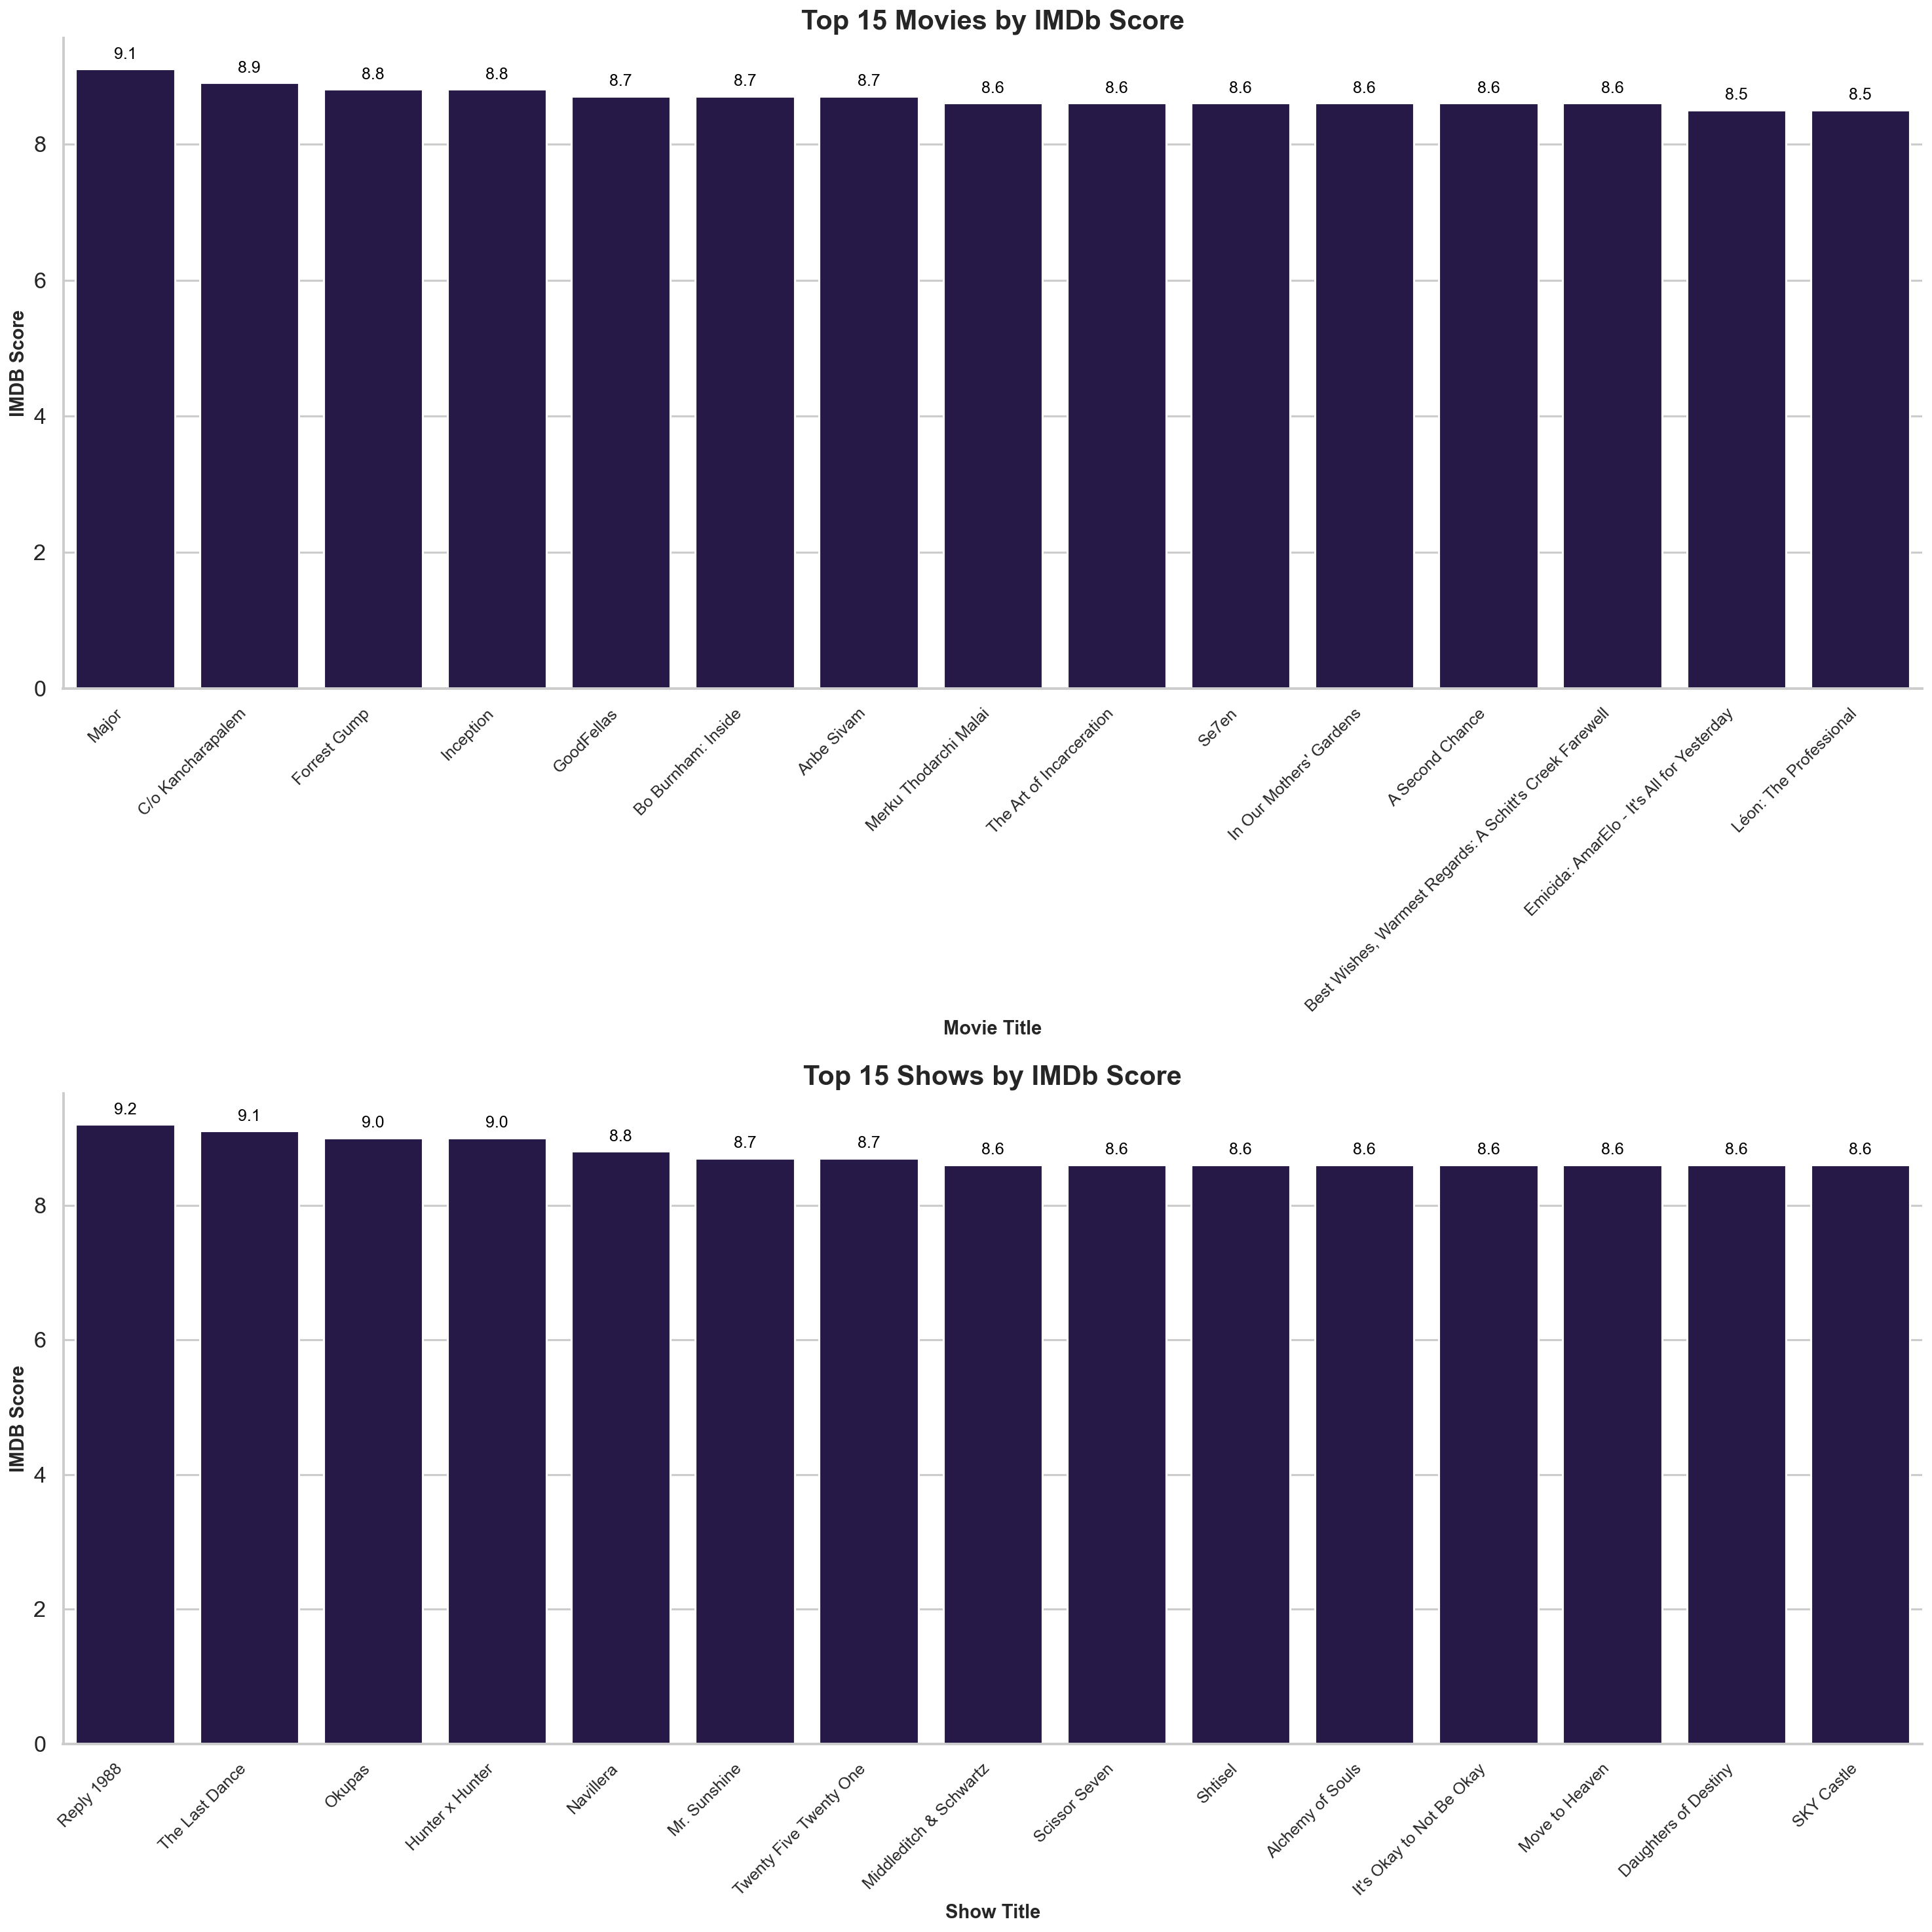

In [138]:
fig, axes = plt.subplots(2, 1, figsize=(20, 20))
types = ['MOVIE', 'SHOW']
titles = ["Top 15 Movies by IMDb Score", "Top 15 Shows by IMDb Score"]

for ax, t, title in zip(axes, types, titles):
    top_k = (
        df_full.loc[df_full['type'] == t, ['title', 'imdb_score']]
        .sort_values(by='imdb_score', ascending=False).head(15)
    )
    
    sns.barplot(data=top_k, x='title', y='imdb_score', ax=ax)

    for p in ax.patches:
        h = p.get_height()
        
        if h > 0:
            ax.annotate(f'{h:.1f}', (p.get_x() + p.get_width() / 2, h), ha='center', va='bottom', fontsize=12,
                        color="black", xytext=(0, 5), textcoords="offset points")
    
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Movie Title" if t == "MOVIE" else "Show Title", fontsize=14, fontweight="bold")
    ax.set_ylabel("IMDB Score", fontsize=14, fontweight="bold")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

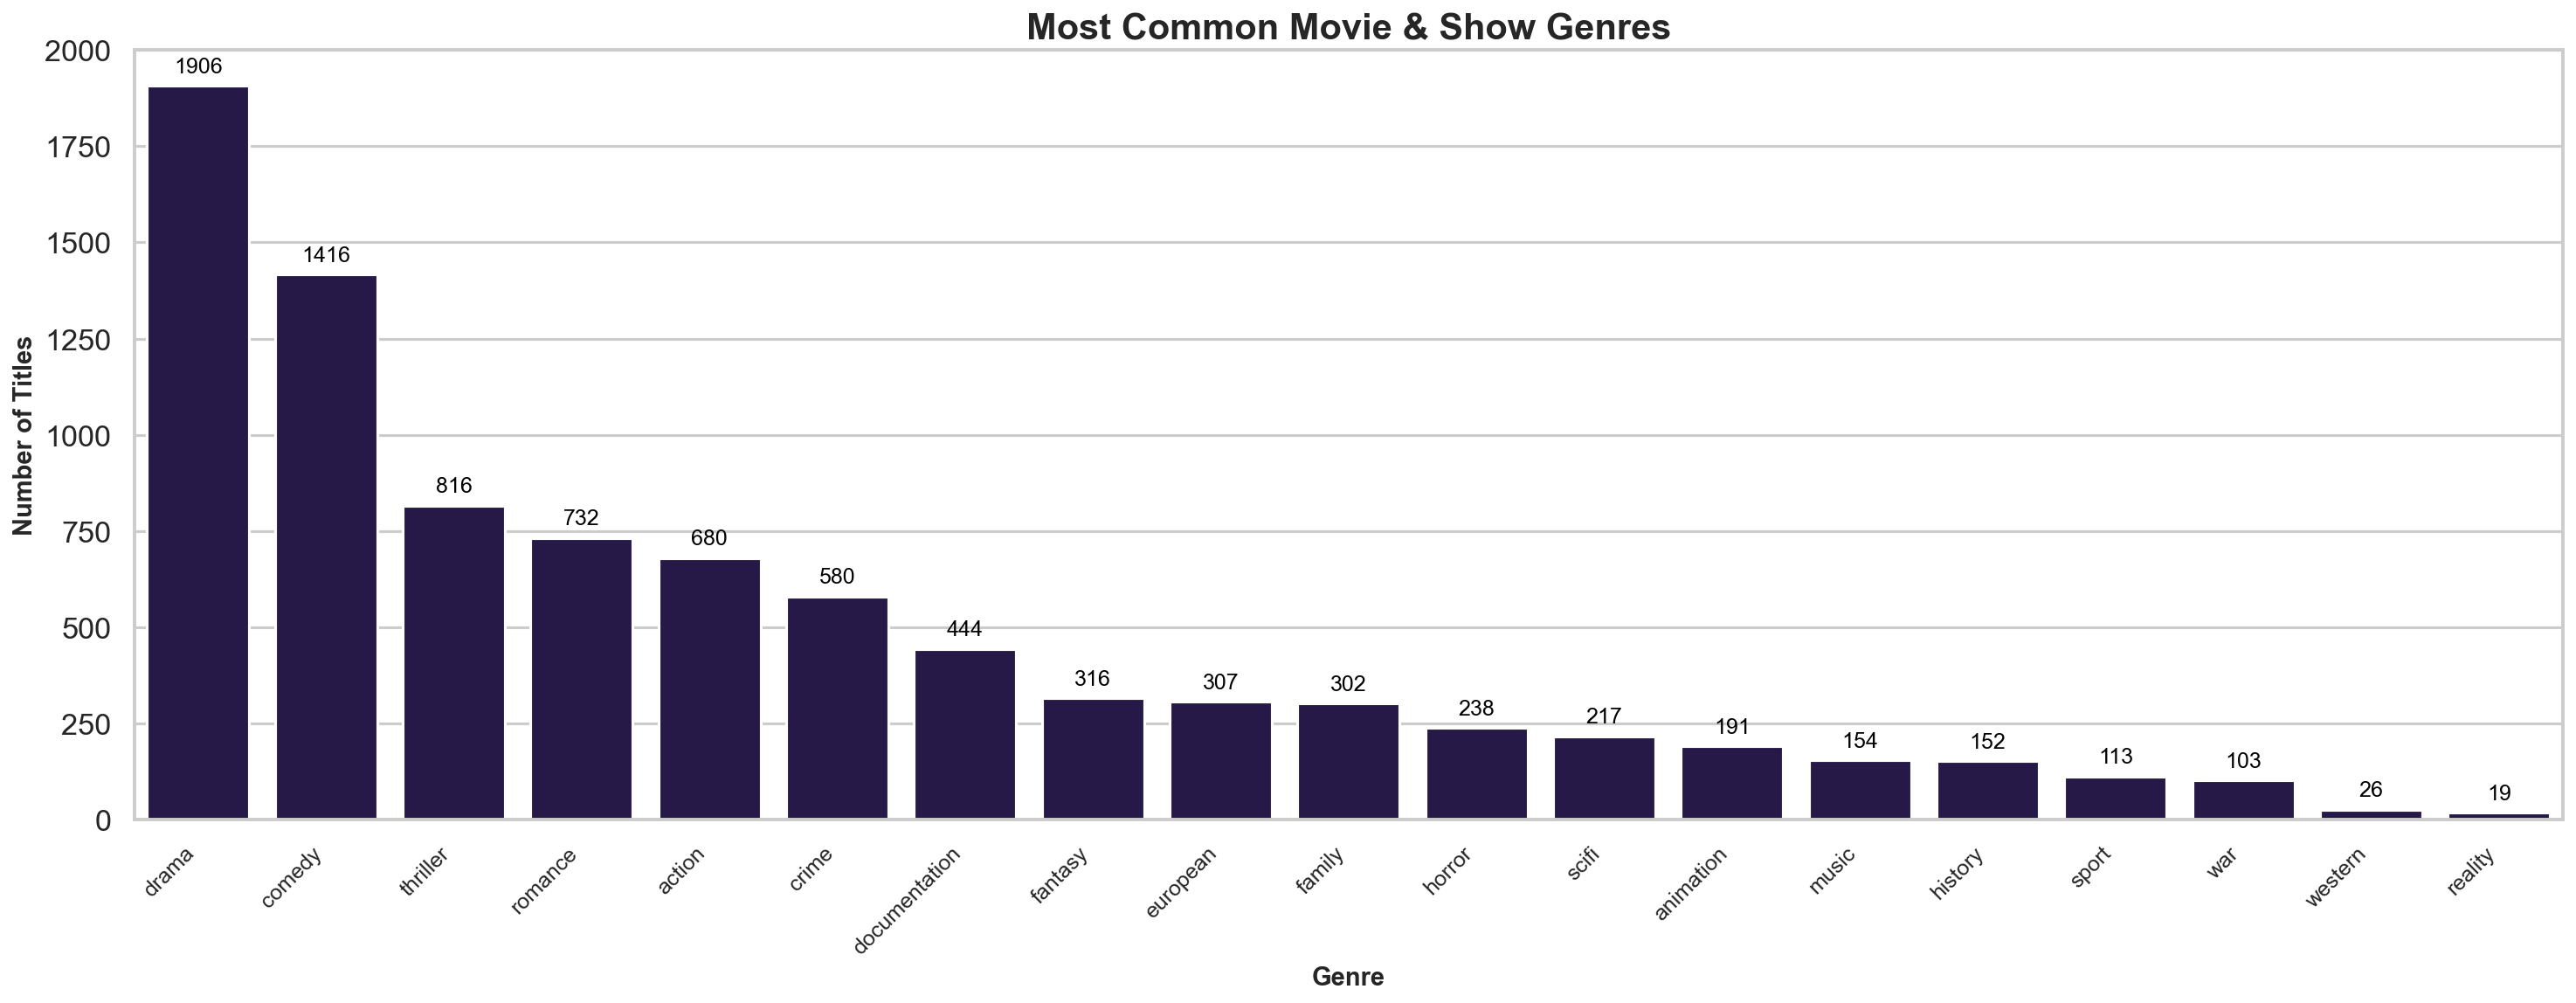

In [139]:
all_genres = [g for val in df_full['genres'].values for g in val]

genre_counts = Counter(all_genres)

df_genres = pd.DataFrame(genre_counts.items(), columns=["genre", "count"])
df_genres_sorted = df_genres.sort_values(by='count', ascending=False)

plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_genres_sorted, x="genre", y="count")

for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2, h),
                    ha='center', va='bottom', fontsize=12,
                    color="black", xytext=(0, 5), textcoords="offset points")

plt.title("Most Common Movie & Show Genres", fontsize=20, fontweight="bold")
plt.xlabel("Genre", fontsize=14, fontweight="bold")
plt.ylabel("Number of Titles", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

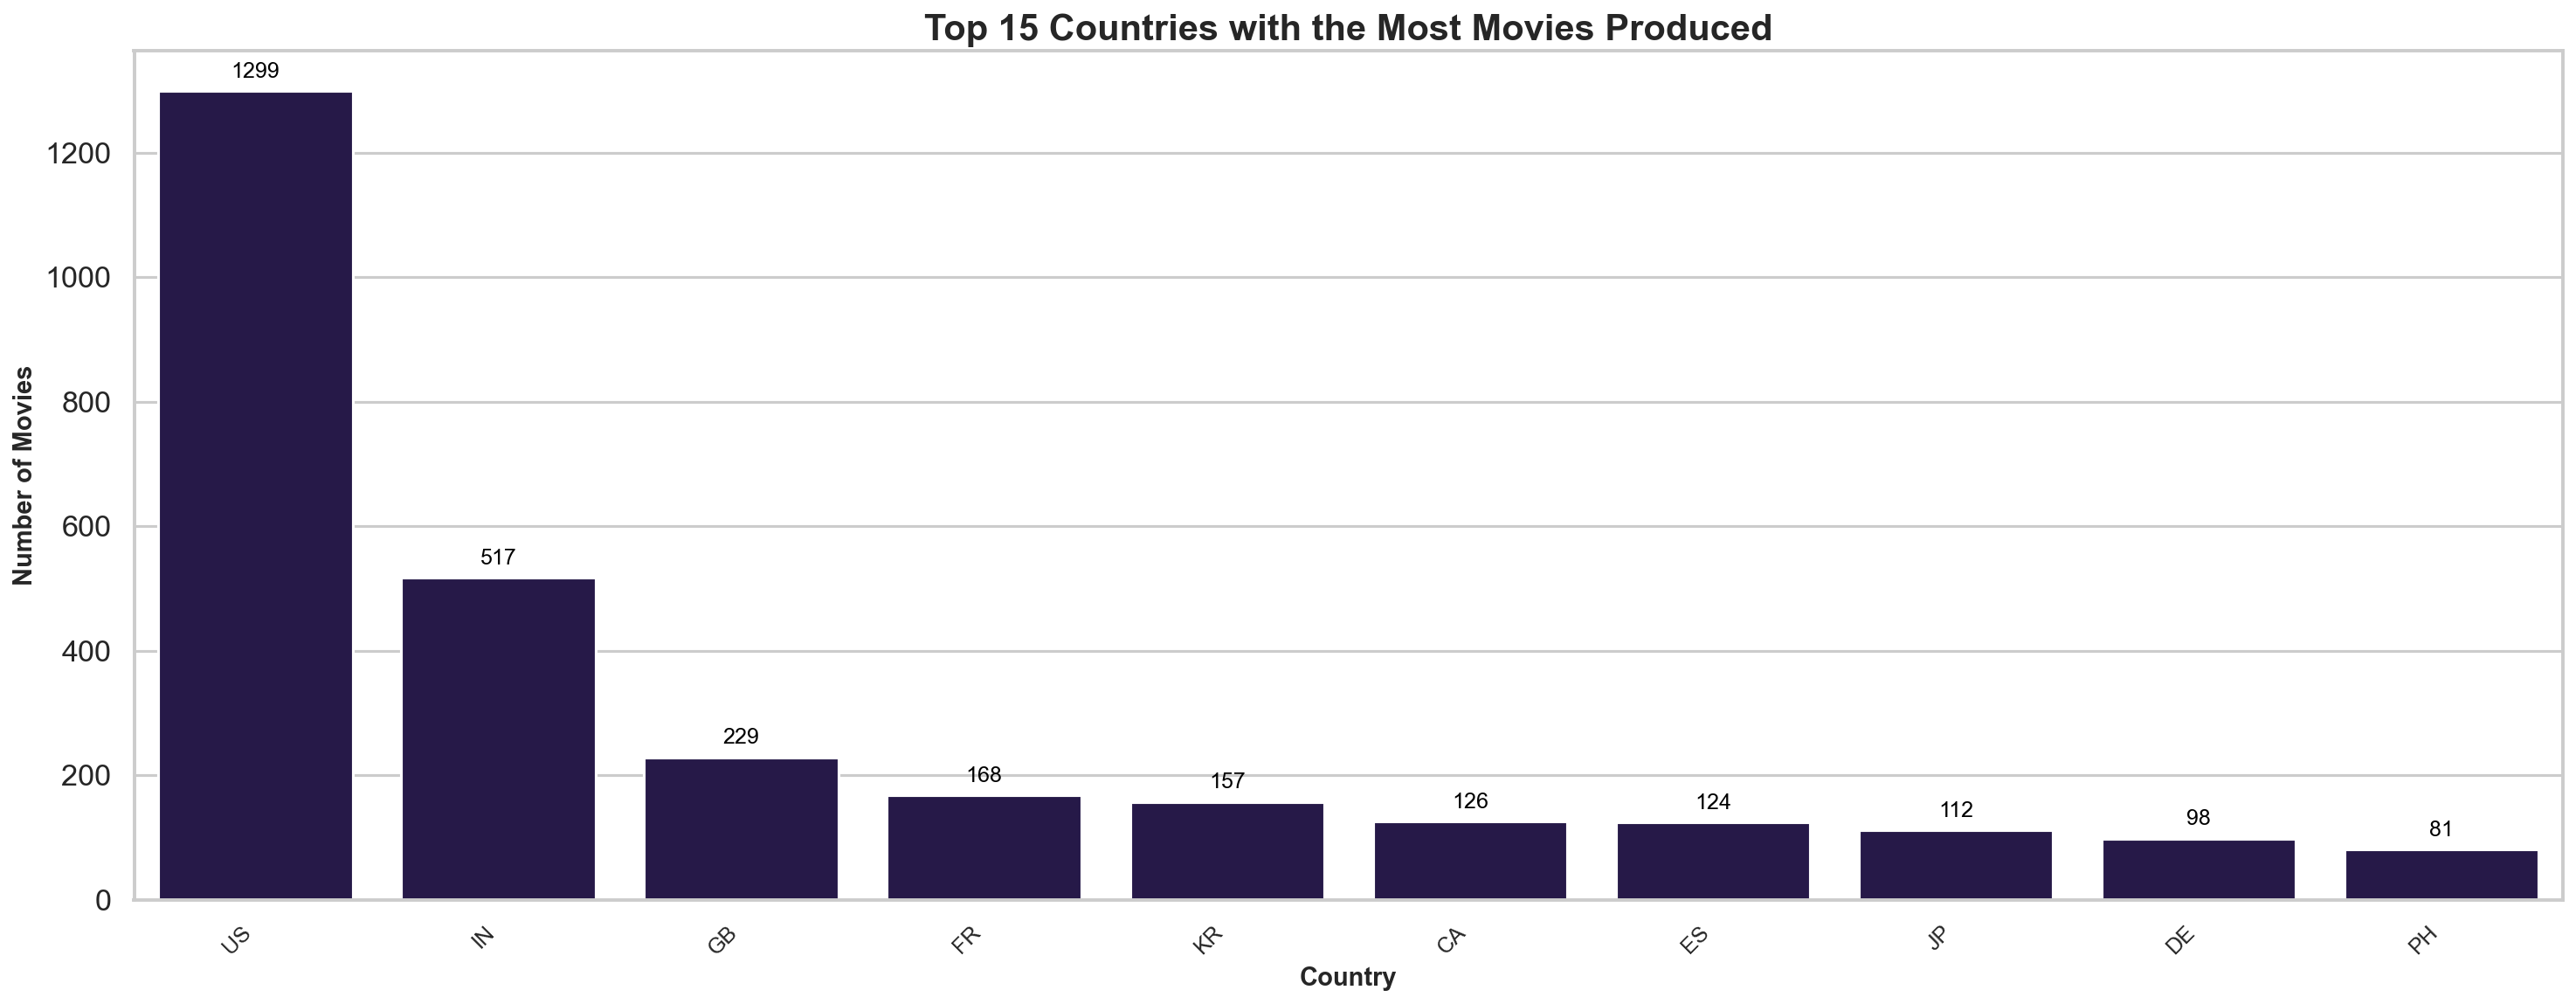

In [140]:
all_countries = [c for val in df_full['production_countries'].values for c in val]

country_counts = Counter(all_countries)

df_countries = pd.DataFrame(country_counts.items(), columns=["country", "count"])
df_countries_sorted = df_countries.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_countries_sorted, x="country", y="count")

for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2, h),
                    ha='center', va='bottom', fontsize=12,
                    color="black", xytext=(0, 5), textcoords="offset points")

plt.title("Top 15 Countries with the Most Movies Produced", fontsize=20, fontweight="bold")
plt.xlabel("Country", fontsize=14, fontweight="bold")
plt.ylabel("Number of Movies", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

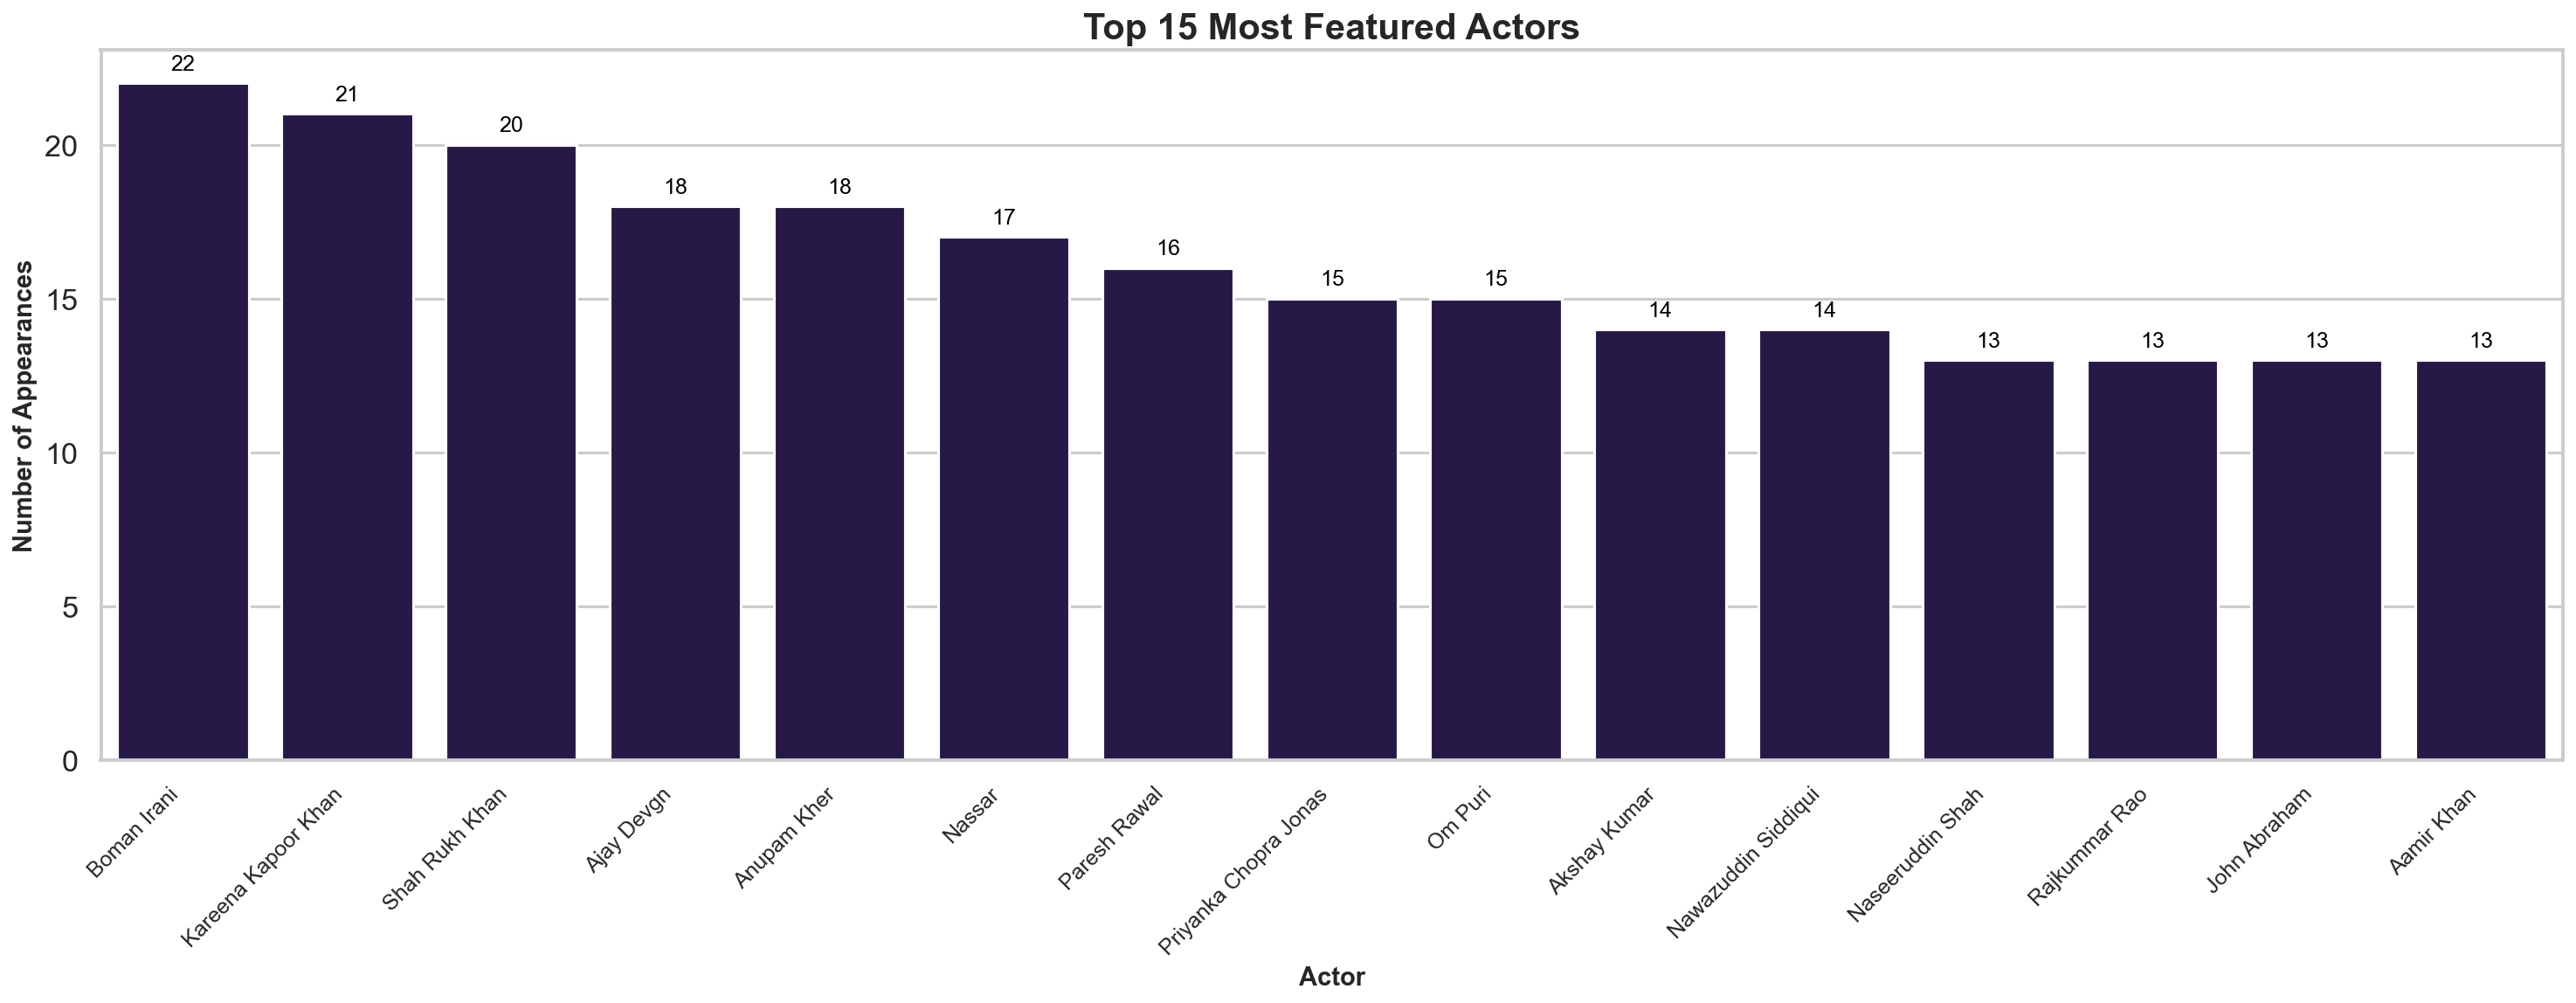

In [141]:
all_actors = [a for val in df_full['actors'].values for a in val]

actors_counts = Counter(all_actors)

df_actors = pd.DataFrame(actors_counts.items(), columns=["actor", "count"])
df_actors_sorted = df_actors.sort_values(by='count', ascending=False).head(15)

plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_actors_sorted, x="actor", y="count")

for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2, h),
                    ha='center', va='bottom', fontsize=12,
                    color="black", xytext=(0, 5), textcoords="offset points")

plt.title("Top 15 Most Featured Actors", fontsize=20, fontweight="bold")
plt.xlabel("Actor", fontsize=14, fontweight="bold")
plt.ylabel("Number of Appearances", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

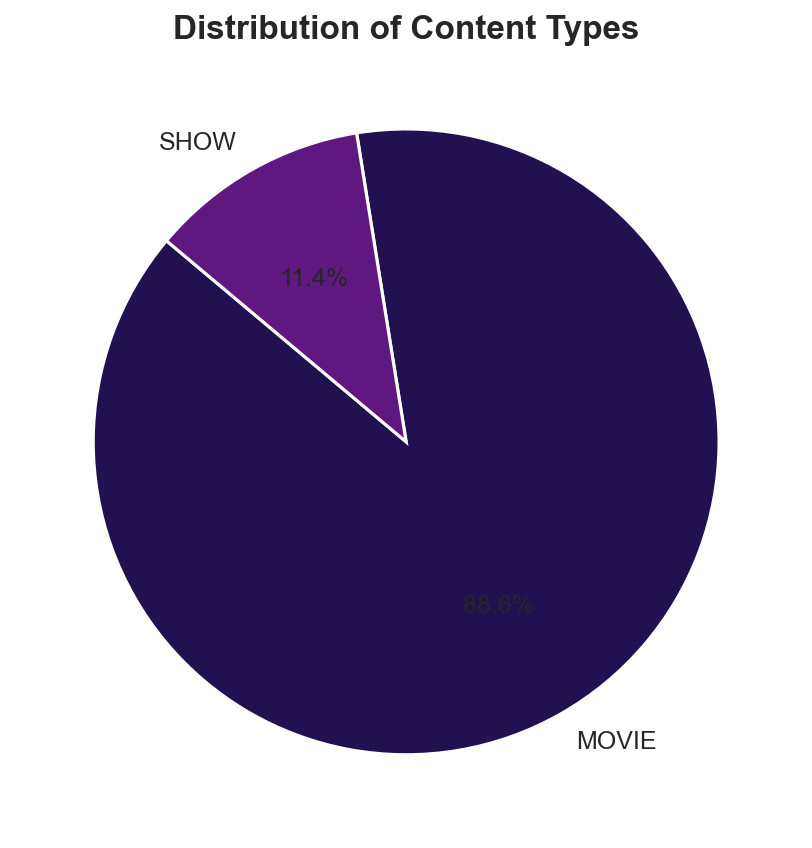

In [142]:
content_type_distribution = df_full['type'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(content_type_distribution, 
        labels=content_type_distribution.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        textprops={'fontsize': 12})

plt.title("Distribution of Content Types", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [143]:
feature_df = df_full[['type', 'description', 'genres', 'actors', 'director']].copy()
movies_info_df = df_full[['id', 'title', 'release_year']].copy()

In [144]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])

def text_preprocessing(text):
    text_doc = nlp(text)
    text_cleaned = [token.lemma_ for token in text_doc if token.is_alpha and not token.is_stop]
    final_text = ' '.join(text_cleaned)
    return final_text

feature_df['description_cleaned'] = feature_df['description'].apply(text_preprocessing)
feature_df['actors'] = feature_df['actors'].apply(lambda val: [x.lower().replace(' ', '_') for x in val])
feature_df['director'] = feature_df['director'].apply(lambda x: x.lower().replace(' ', '_'))

feature_df.head()

,type,description,genres,actors,director,description_cleaned
1,MOVIE,A mentally unstable Vietnam War veteran works ...,"[drama, crime]","[robert_de_niro, jodie_foster, albert_brooks, ...",martin_scorsese,mentally unstable Vietnam War veteran work nig...
2,MOVIE,Intent on seeing the Cahulawassee River before...,"[drama, action, thriller, european]","[jon_voight, burt_reynolds, ned_beatty, ronny_...",john_boorman,intent see Cahulawassee River turn huge lake o...
4,MOVIE,12 American military prisoners in World War II...,"[war, action]","[lee_marvin, ernest_borgnine, charles_bronson,...",robert_aldrich,american military prisoner World War II order ...
6,MOVIE,"Brian Cohen is an average young Jewish man, bu...",[comedy],"[graham_chapman, john_cleese, terry_gilliam, e...",terry_jones,Brian Cohen average young jewish man series ri...
7,MOVIE,When a madman dubbed 'Scorpio' terrorizes San ...,"[thriller, action, crime]","[clint_eastwood, harry_guardino, reni_santoni,...",don_siegel,madman dub Scorpio terrorize San Francisco har...


In [145]:
def title_preprocessing(title):
    title = title.lower()
    title_cleaned = re.sub(r'[^\w\d\s]+', '', title)
    title_cleaned = re.sub(r'\s+', ' ', title_cleaned)
    return title_cleaned
    
movies_info_df['title'] = movies_info_df['title'].apply(title_preprocessing)

movies_info_df.head()

,id,title,release_year
1,tm84618,taxi driver,1976
2,tm154986,deliverance,1972
4,tm120801,the dirty dozen,1967
6,tm70993,life of brian,1979
7,tm14873,dirty harry,1971


In [146]:
def concat_features(X):
    combined_text = []
    
    for val in X.values:
        if isinstance(val, list):
            combined_text.extend(val)
        elif isinstance(val, str):
            combined_text.append(val)
    
    return " ".join(combined_text)
feature_df['full_feature'] = feature_df.apply(lambda x: concat_features(x), axis=1)
feature_df['full_feature']

1       MOVIE A mentally unstable Vietnam War veteran ...
2       MOVIE Intent on seeing the Cahulawassee River ...
4       MOVIE 12 American military prisoners in World ...
6       MOVIE Brian Cohen is an average young Jewish m...
7       MOVIE When a madman dubbed 'Scorpio' terrorize...
                              ...                        
5839    MOVIE Jack - a Chinese chef-manager who is in-...
5841    MOVIE Reese is a con artist from Manila who dr...
5843    MOVIE The story follows a young man and woman ...
5845    MOVIE A beautiful love story that can happen b...
5847    MOVIE A controversial TV host and comedian who...
Name: full_feature, Length: 3293, dtype: object

In [147]:
vectorizer = TfidfVectorizer()

vectorizer.fit(feature_df['full_feature'])
feature_vectors = vectorizer.transform(feature_df['full_feature'])

In [148]:
similarity_matrix = cosine_similarity(feature_vectors)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=movies_info_df['id'].values, columns=movies_info_df['id'].values)
print(f'Similarity Matrix Shape: {similarity_matrix.shape}')
similarity_matrix_df.iloc[:5, :20]

Similarity Matrix Shape: (3293, 3293)


,tm84618,tm154986,tm120801,tm70993,tm14873,tm119281,tm98978,tm44204,tm67378,tm69997,tm16479,tm135083,tm89386,tm156453,tm14350,tm81728,tm94651,tm27298,tm19608,tm204541
tm84618,1.000000,0.005778,0.063180,0.004137,0.007493,0.047376,0.008645,0.014224,0.005968,0.003801,0.037102,0.005899,0.003572,0.090930,0.028126,0.003216,0.014662,0.016079,0.006631,0.007144
tm154986,0.005778,1.000000,0.023556,0.003412,0.012446,0.027649,0.014047,0.004011,0.006716,0.005921,0.007584,0.003138,0.006078,0.006687,0.011768,0.005463,0.018949,0.005964,0.006689,0.017979
tm120801,0.063180,0.023556,1.000000,0.007387,0.026011,0.044197,0.016371,0.145854,0.041132,0.004285,0.034756,0.038288,0.017550,0.082860,0.099189,0.013255,0.030078,0.059726,0.015576,0.015107
tm70993,0.004137,0.003412,0.007387,1.000000,0.008801,0.008952,0.014679,0.005959,0.003385,0.004431,0.011970,0.023421,0.011155,0.009370,0.032808,0.006690,0.013389,0.006041,0.026169,0.012657
tm14873,0.007493,0.012446,0.026011,0.008801,1.000000,0.009819,0.009294,0.015648,0.017320,0.009287,0.007444,0.012417,0.008847,0.011801,0.005867,0.008994,0.098137,0.007223,0.012742,0.011041


In [149]:
def recommend_movie(movie_name, sim_matrix, infos_df, release_year, k):
    if not movie_name:
        raise Exception("Movie name cannot be empty.")
    
    if not release_year:
        raise Exception("Release year cannot be empty.")

    if k >= len(sim_matrix):
        k = len(sim_matrix)
    
    preprocessed_movie_name = title_preprocessing(movie_name)
    
    movie_id_filtered_by_title = infos_df[infos_df['title'] == preprocessed_movie_name]
    
    if movie_id_filtered_by_title.empty:
        raise Exception("Movie Name Not Found")
    
    movie_id_filtered_by_year = movie_id_filtered_by_title[movie_id_filtered_by_title['release_year'] == int(release_year)]
    
    if movie_id_filtered_by_year.empty:
        raise Exception("Movie Name Release Year is Incorrect")
    
    movie_id = movie_id_filtered_by_year['id'].values[0]
        
    similar_movies = sim_matrix[movie_id].drop(index=movie_id)
    top_k_similar_movies = similar_movies.sort_values(ascending=False)[:k]
    
    similar_movie_names = infos_df[infos_df['id'].isin(top_k_similar_movies.index)]['title'].tolist()
    
    return similar_movie_names

In [151]:
movie_name = input('Enter a movie name: ')
movie_release_year = input('Enter a movie release year: ')

# 'Taxi Driver 1976'
try:
    recommends = recommend_movie(
        movie_name=movie_name,
        release_year=movie_release_year,
        sim_matrix=similarity_matrix_df, 
        infos_df=movies_info_df, k=30
    )
    
    print('Recommendations:')
    
    for i, recommend in enumerate(recommends, 1):
        print(i, '-', recommend)
    
except Exception as e:
    print(e)

Recommendations:
1 - a river runs through it
2 - rambo
3 - friday the 13th
4 - the cave
5 - interview with a serial killer
6 - trailer park boys say goodnight to the bad guys
7 - bully
8 - kai po che
9 - eyes of a thief
10 - blackhat
11 - heneral luna
12 - geralds game
13 - the long dumb road
14 - hey arnold the jungle movie
15 - the invisible guardian
16 - the tree of blood
17 - food on the go
18 - remastered who killed jam master jay
19 - love you to the stars and back
20 - see you yesterday
21 - coven
22 - 4 latas
23 - the binding
24 - the path of the anaconda
25 - ultras
26 - the stand at paxton county
27 - till death
28 - sas red notice
29 - theres someone inside your house
30 - prey
